# HackOnAzure Analysis:

### Importing Libraries:

In [2]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples
import folium
import os
import requests
import json
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objs as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input,Output,State
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


### Load Dataset:

In [3]:
# Load Data

df_ox = pd.read_parquet("https://pandemicdatalake.blob.core.windows.net/public/curated/covid-19/covid_policy_tracker/latest/covid_policy_tracker.parquet")
df_ox.rename(columns = {'countryname':'Country/Region','date':'Date'},inplace=True)
df_ox['Date'] = pd.to_datetime(df_ox['Date'])
df_ox.rename(index = {'United States':'US'},inplace=True)


# URL of the raw dataset provided by John Hopkins University
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

# Importing CSV files from John Hopkins Github Dataset
df_cases = pd.read_csv(url_cases)                
df_deaths = pd.read_csv(url_deaths)                      
df_recovered = pd.read_csv(url_recovered)
#print(df_cases.head())

dates = df_cases.columns[4:]

df_cases_melt = df_cases.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed')

df_deaths_melt = df_deaths.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths'
)
df_recovered_melt = df_recovered.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered'
)

# Merging all three csv files
df_data = pd.DataFrame()

df_data = df_cases_melt.merge(
  right=df_deaths_melt, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

df_data = df_data.merge(
  right=df_recovered_melt, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)


# Converting the column Date as a DateTime object
df_data['Date'] = pd.to_datetime(df_data['Date'])
# Check for any missing values
#print(df_data.isna().sum())
# Replacing any missing values in Recovered column as 0 as it is the only possible explanation to it
df_data['Recovered'] = df_data['Recovered'].fillna(0)
# Replacing missing values in State column as some countries do not update the statewise data
df_data['Province/State'] = df_data['Province/State'].fillna(df_data['Country/Region'])
# Re-check missing values :
#print(df_data.isna().sum())

# Remoing the Ships data from the table as this project is focussed on a country level dataset
filter_1 = df_data['Country/Region'].str.contains('MS Zaandam')
filter_2 = df_data['Country/Region'].str.contains('Diamond Princess')
filter_3 = df_data['Province/State'].str.contains('Diamond Princess')
filter_4 = df_data['Province/State'].str.contains('Grand Princess')

df_data = df_data[~(filter_1 | filter_2 | filter_3 | filter_4)]

#print(df_data)

# Active Case = confirmed - (deaths + recovered)
df_data['Active'] = df_data['Confirmed'] - (df_data['Deaths'] + df_data['Recovered'])
#print(df_data)

# We dont need State data for country-wise analysis. 
# Removing the Latitude and Longitude columns as well because for the countries with specified data columns, Lat and Long data are different.
# While plotting in folium, we will definitely need that data, but I will be using geopy package to get that data.
df = pd.DataFrame()
df = df_data.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
#print(df)


# Also including Daily stats in df for better visualization and understanding in the later steps such as Data exploration and Visualization
df_temp = df.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
df_temp = df_temp.sum().diff().reset_index()
df_new = df_temp['Country/Region'] != df_temp['Country/Region'].shift(1)
df_temp.loc[df_new, 'Confirmed'] = np.nan
df_temp.loc[df_new, 'Deaths'] = np.nan
df_temp.loc[df_new, 'Recovered'] = np.nan
# renaming columns
df_temp.columns = ['Country/Region', 'Date', 'New_Cases', 'New_Deaths', 'New_Recovered']
# merging new values
df = pd.merge(df, df_temp, on=['Country/Region', 'Date'])
# filling na with 0
df = df.fillna(0)
# fixing data types
cols = ['New_Cases', 'New_Deaths', 'New_Recovered']
df[cols] = df[cols].astype('int')
df['New_Cases'] = df['New_Cases'].apply(lambda x: 0 if x<0 else x)


# Worldometer Data taken from OWID : 

df_owid = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv',parse_dates = True)
filt_d = df_owid['location'].isin(['World','International'])
df_owid.drop(df_owid.loc[filt_d].index,axis=0,inplace=True)
df_owid['combined_smokers'] = df_owid['female_smokers'] + df_owid['male_smokers']

df_owid.rename(columns = {'location':'Country/Region','date':'Date'},inplace=True)
df_owid.set_index('Country/Region',inplace=True)
df_owid.rename(index = {'United States':'US'},inplace=True)
df_owid['Date'] = pd.to_datetime(df_owid['Date'])
df_owid.reset_index()

df_owid.drop(columns=['iso_code', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million'],axis=1,inplace=True)

dfs=df.copy()
dfs = dfs.merge(right=df_owid, how='left', on=['Country/Region','Date'])
dfs.fillna(0)
df1 = dfs
df1 = df1.merge(right=df_ox,how='left',on=['Country/Region','Date'])
df=df1
df.isna().sum()
df.fillna(0)
df['Date'] = pd.to_datetime(df['Date'])
#df.head()
print()

In [4]:
temp_array_lat = []
temp_array_lon = []
i = 0

df2 = pd.DataFrame()
df2['Country/Region'] = df['Country/Region'].unique()
len_df2 = df2['Country/Region'].count()

def Geo_Locations(x):
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(x)
        latitude = location.latitude
        longitude = location.longitude
        return (latitude , longitude)
    except:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(x)
        latitude = location.latitude
        longitude = location.longitude
        return (latitude , longitude)

In [5]:
while i<len_df2:
    temp1,temp2 = Geo_Locations(df2['Country/Region'][i])
    temp_array_lat.append(temp1)
    temp_array_lon.append(temp2)
    i = i+1

df2['Latitude'] = temp_array_lat
df2['Longitude'] = temp_array_lon

df = df.merge(right=df2, how='left', on=['Country/Region'])
#df.head(2)
df.replace(np.nan,0,inplace=True)
df.head(2)
print('Locations found and mapped!')

Locations found and mapped!


## Global Data Exploration and Visualization

In [6]:
# First 10 countries to be affected by COVID19 :

temp = df.copy()
dfx = temp[temp['New_Cases'] > 0]
dfx = dfx.sort_values('Date',ascending=True)
dfx = dfx['Country/Region'].unique()[0:10].tolist()
df_first = temp[temp['Country/Region'].isin(dfx)].reset_index()
#df_first['Country/Region'].unique()

In [7]:
# Countries to cross Total Cases over 200K :
temp = df.copy()
filt_7 = temp['Confirmed'] > 200000
dfx = temp.loc[filt_7]
dfx = dfx.sort_values('Date',ascending=True)
dfx = dfx['Country/Region'].unique()[0:].tolist()
df_100k = temp[temp['Country/Region'].isin(dfx)].reset_index()
#df_100k['Country/Region'].unique()

#### Countries above 100k cases

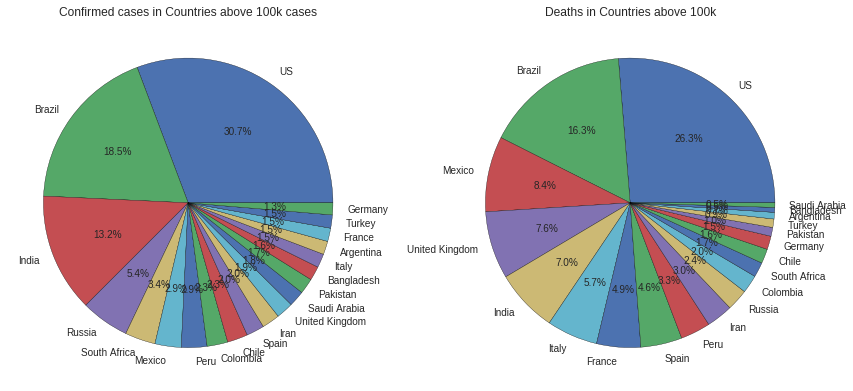

In [8]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2,figsize=(12,12))

y1 = df_100k.groupby('Country/Region')['New_Cases'].sum().sort_values(ascending = False)
x1 = pd.DataFrame(y1,columns = ['New_Cases'])
x1 = x1.reset_index()
y2 = df_100k.groupby('Country/Region')['New_Deaths'].sum().sort_values(ascending = False)
x2 = pd.DataFrame(y2,columns = ['New_Deaths'])
x2 = x2.reset_index()

ax1.pie(x1['New_Cases'],labels = x1['Country/Region'] , wedgeprops = {'edgecolor':'black'},autopct='%1.1f%%')
ax2.pie(x2['New_Deaths'],labels = x2['Country/Region'] , wedgeprops = {'edgecolor':'black'},autopct='%1.1f%%')

ax1.set_title('Confirmed cases in Countries above 100k cases')
ax2.set_title('Deaths in Countries above 100k')

plt.tight_layout()
plt.show()

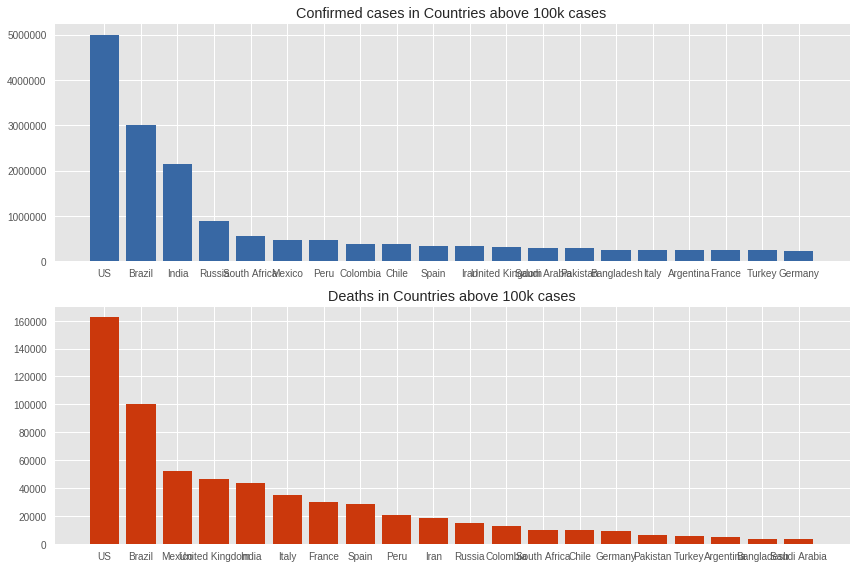

In [9]:

import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols=1,figsize=(12,8))


y1 = df_100k.groupby('Country/Region')['New_Cases'].sum().sort_values(ascending = False)
x1 = pd.DataFrame(y1,columns = ['New_Cases'])
x1 = x1.reset_index()

y2 = df_100k.groupby('Country/Region')['New_Deaths'].sum().sort_values(ascending = False)
x2 = pd.DataFrame(y2,columns = ['New_Deaths'])
x2 = x2.reset_index()


ax1.bar(x1['Country/Region'], x1['New_Cases'],color='#3868A4')
ax2.bar(x2['Country/Region'], x2['New_Deaths'],color='#CB380C')


ax1.set_title('Confirmed cases in Countries above 100k cases')
ax2.set_title('Deaths in Countries above 100k cases')

plt.tight_layout()
plt.show()

#### Countries where COVID-19 cases was first reported

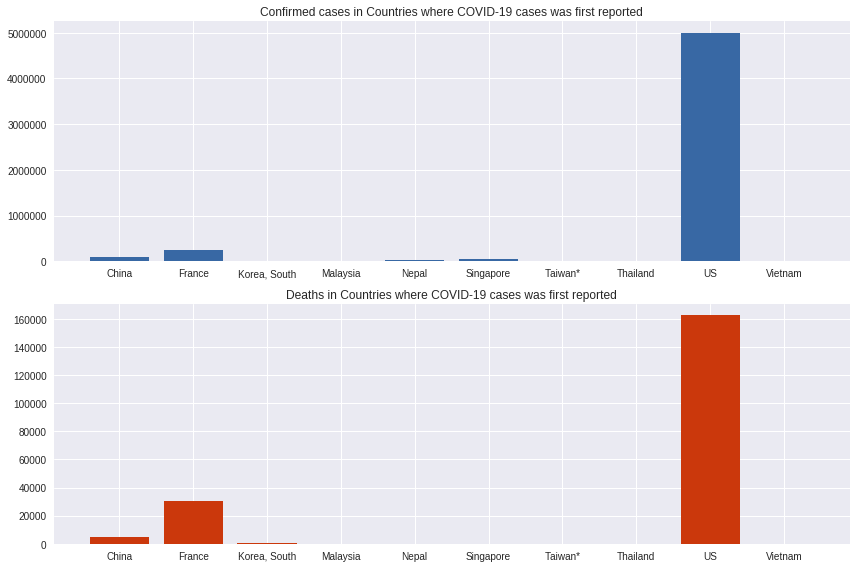

In [10]:

import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols=1,figsize=(12,8))


y1 = df_first.groupby('Country/Region')['New_Cases'].sum()
x1 = pd.DataFrame(y1,columns = ['New_Cases'])
x1 = x1.reset_index()

y2 = df_first.groupby('Country/Region')['New_Deaths'].sum()
x2 = pd.DataFrame(y2,columns = ['New_Deaths'])
x2 = x2.reset_index()


ax1.bar(x1['Country/Region'], x1['New_Cases'],color='#3868A4')
ax2.bar(x2['Country/Region'], x2['New_Deaths'],color='#CB380C')


ax1.set_title('Confirmed cases in Countries where COVID-19 cases was first reported')
ax2.set_title('Deaths in Countries where COVID-19 cases was first reported')

plt.tight_layout()
plt.show()

In [11]:

#c1 = ['China', 'France', 'Korea, South', 'Malaysia', 'Nepal','Singapore', 'Taiwan*', 'Thailand', 'US', 'Vietnam']
#c2 = ['Brazil', 'Chile', 'France', 'Germany', 'Iran', 'Italy','Peru', 'Russia', 'Spain', 'Turkey', 'US', 'United Kingdom']

c1 = df_first['Country/Region'].unique().tolist()
c2 = df_100k['Country/Region'].unique().tolist()


In [12]:
def Stats(val):
    c = str(val)
    filt_c = df['Country/Region']==c
    filt_C = df['Confirmed'] > 0
    dfc = df.loc[filt_c & filt_C]

    import matplotlib.pyplot as plt
    fig,(ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols=1,figsize=(12,8))
    plt.style.use('seaborn')

    x = dfc['Date']
    y1 = dfc['Confirmed']
    y2 = dfc['Deaths']
    y3 = dfc['Recovered']

    ax1.plot(x,y1,color = 'blue')
    ax2.plot(x,y2,color = 'red')
    ax3.plot(x,y3,color = 'green')

    plt.grid(True)
    ax1.set_title('Confirmed Cases')
    plt.grid(True)
    ax2.set_title('Deaths')
    plt.grid(True)
    ax3.set_title('Recovered')

    plt.tight_layout()
    return plt.show()

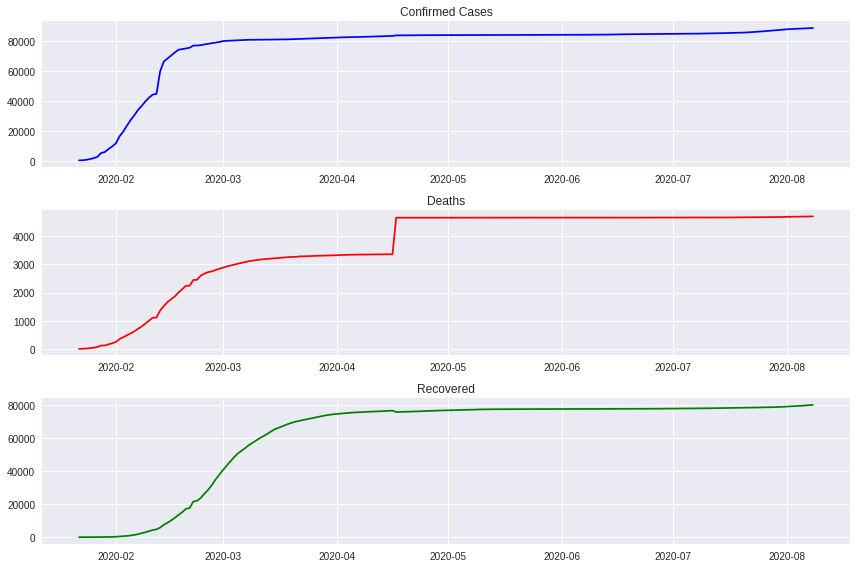

In [13]:
c = 'China'

#c1 = ['China', 'France', 'Korea, South', 'Malaysia', 'Nepal','Singapore', 'Taiwan*', 'Thailand', 'US', 'Vietnam']
#c2 = ['Brazil', 'Chile', 'France', 'Germany', 'Iran', 'Italy','Peru', 'Russia', 'Spain', 'Turkey', 'US', 'United Kingdom']
Stats(c)

#### Updated Global Counts for Histograms :

In [14]:
dfp = df
dfp = dfp.groupby(['Country/Region'])[
    'Confirmed', 'Deaths', 'Recovered', 'Active','total_tests',
    'population', 'population_density', 'median_age','gdp_per_capita', 'extreme_poverty', 'diabetes_prevalence','handwashing_facilities', 'hospital_beds_per_thousand',
       'combined_smokers', 'Latitude', 'Longitude'].max().reset_index().rename(columns={"index": "x"})
dfp['Day']=dfp.index + 1
dfp.replace(np.nan,0,inplace=True)

## Histograms :

<p>A histogram is an approximate representation of the distribution of numerical or categorical data. It was first introduced by Karl Pearson.</p> 
<p>To construct a histogram, the first step is to "bin" the range of values—that is, divide the entire range of values into a series of intervals—and then count how many values fall into each interval. The bins are usually specified as consecutive, non-overlapping intervals of a variable. </p>

### Analysis Based on Population :

In [15]:

import plotly.express as px
fig = px.histogram(dfp, x="population",y='Confirmed')
fig.show()

In [16]:
import plotly.express as px
fig = px.histogram(dfp, x="population",y='Deaths')
fig.show()

####  Analysis of Population vs Confirmed Cases / Deaths :
<p>Histogram is Bimodal between 0-350M.</p>
<p>i.e, there are 2 different groups of 0-150M and 200 to 350M.</p>
<p>3rd group is 1 Billion+ which includes only india and china </p>

In [17]:
# Splitting the 3 groups of countries :

In [18]:
filt_a = dfp['population'] < 150000000
filt_b1 = dfp['population'] > 200000000
filt_b2 = dfp['population'] < 300000000
filt_c = dfp['population'] > 1000000000

group_a = dfp.loc[filt_a]
group_b = dfp.loc[filt_b1 & filt_b2]
group_c = dfp.loc[filt_c]

ac = group_a['Confirmed'].sum()
bc = group_b['Confirmed'].sum()
cc = group_c['Confirmed'].sum()

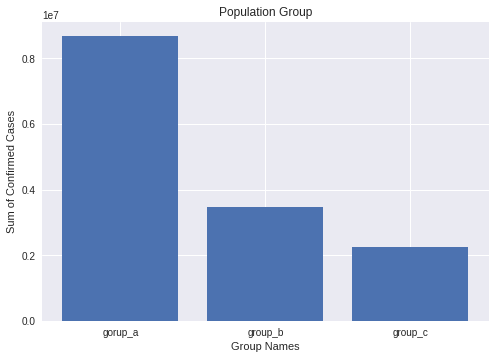

In [19]:

plt.bar(['gorup_a','group_b','group_c'],[ac,bc,cc])

plt.xlabel('Group Names')
plt.ylabel('Sum of Confirmed Cases')
plt.title('Population Group')

plt.show()

### Analysis based on the GDP of the Countries :

In [20]:
import plotly.express as px
fig = px.histogram(dfp, x="extreme_poverty",y='hospital_beds_per_thousand')
fig.show()

####  Analysis of Poverty Ratio vs Hospital_Beds_per_1000 :
<p>Histogram is Skewed Right.</p>
<p>i.e, the Countries having least poverty ratio( comparatively better GDP per capita ) have been impacted the most by the virus outbreak.</p>
<p> The most prominent reason is the International travels are at a higher scale in these countries </p>
<p>The Countries having least poverty ratio have arranged and utilized majority of the hospital beds.</p>
<p>However, Countries within range of 2.5 to 7.4 could only arrange an average of 34 beds per 1000 patients.</p>

In [21]:
# Skewed right. i.e, countries with gdp per capita less have better resourcefulness towards hospital beds
import plotly.express as px
fig = px.histogram(dfp, x="gdp_per_capita",y='hospital_beds_per_thousand')
fig.show()

####  Analysis of GDP_per_capita vs Hospital_Beds_pre_1000 :
<p>Histogram is Skewed Right.</p>
<p>i.e, countries with gdp per capita less have better resourcefulness towards hospital beds</p>


In [22]:
# Analyze countries with gdp above 47.5K and least extreme_poverty that have low hospital_beds_per_1000 :

In [23]:
filt_p1 = dfp['extreme_poverty'] > 2.5
filt_p2 = dfp['extreme_poverty'] < 7.4
filt_g2 = dfp['gdp_per_capita'] > 47500

df_pov = dfp.loc[filt_p1 & filt_p2].reset_index()
df_gdp_48k = dfp.loc[filt_g2].reset_index()


In [24]:
df_hosp = df_pov.merge(right=df_gdp_48k,how='outer',on=['index', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'total_tests', 'population', 'population_density', 'median_age',
       'gdp_per_capita', 'extreme_poverty', 'diabetes_prevalence',
       'handwashing_facilities', 'hospital_beds_per_thousand',
       'combined_smokers', 'Latitude', 'Longitude', 'Day'])
df_hosp['Mortality_Rate_Covid19'] = (df_hosp['Deaths'] / df_hosp['Confirmed'])*100
df_hosp['Active_Cases'] = (df_hosp['Active'] / df_hosp['Confirmed'])*100
df_hosp = df_hosp.sort_values(by=['Mortality_Rate_Covid19'],ascending=False)

In [25]:
print('The total number of Countries with Higher GDP and Low Hospital_Beds_per_1000 are : ',df_hosp['Country/Region'].count())

The total number of Countries with Higher GDP and Low Hospital_Beds_per_1000 are :  26


<b>However, on adding Mortality rate due to COVID-19, The following countries have Mortality rate below 1 percent and the still active cases have reduced at a significant margin</b>


In [26]:
df_Low_Mortality =df_hosp[df_hosp['Mortality_Rate_Covid19']<1.0][['Country/Region','gdp_per_capita','Mortality_Rate_Covid19','Active_Cases']]
df_Low_Mortality

,Country/Region,gdp_per_capita,Mortality_Rate_Covid19,Active_Cases
12,Tajikistan,2896.913,0.804568,24.591228
15,Kuwait,65530.537,0.665740,22.234863
4,Gabon,16562.413,0.643696,39.669317
25,United Arab Emirates,67293.483,0.571429,27.565008
19,Qatar,116935.600,0.161562,31.632490
22,Singapore,85535.383,0.049154,37.865244


<b>The Countries with low poverty index but higher mortality due to COVID-19 outbreak are as follows :</b>

In [27]:
filt_impact = df_hosp['Mortality_Rate_Covid19']>1.0
filt_risk = df_hosp['Active_Cases']>50.0
filt_low_risk = df_hosp['Active_Cases']<50.0


In [28]:
df_low_Impacted = df_hosp.loc[filt_impact & filt_low_risk][
    ['Country/Region','gdp_per_capita','Mortality_Rate_Covid19','Active_Cases']]
df_low_Impacted

,Country/Region,gdp_per_capita,Mortality_Rate_Covid19,Active_Cases
3,Ecuador,10581.936,6.322404,47.325055
23,Switzerland,57410.166,5.448410,39.365175
6,Indonesia,11188.744,4.581265,31.204910
10,Peru,12236.706,4.451415,27.786365
11,Romania,23313.199,4.386124,46.338848
1,Brazil,14103.452,3.335434,19.604589
2,Colombia,13254.949,3.327407,42.385703
8,Nicaragua,5321.444,3.152230,30.702204
7,Mauritania,3597.633,2.411674,45.591398
9,Pakistan,5034.708,2.140486,38.323450


<b> The Above Countries have the following attributes : </b>
<li> Low Extreme_Poverty index or Higher GDP per capita</li>
<li> Low Hospital Beds per 1000 Patients</li>
<li> Higher Mortality rate due to COVID-19</li>
<li> But the number of active cases  have reduced significantly</li>
<p></p>
<b> Hence, the above countries need to follow their current containment measures.</b>

In [29]:
df_Most_Impacted = df_hosp.loc[filt_impact & filt_risk][
    ['Country/Region','gdp_per_capita','Mortality_Rate_Covid19','Active_Cases']]
df_Most_Impacted

,Country/Region,gdp_per_capita,Mortality_Rate_Covid19,Active_Cases
17,Netherlands,48472.545,10.521655,89.074714
14,Ireland,67335.293,6.650653,55.877496
20,San Marino,56861.470,6.008584,67.954220
0,Bolivia,6885.829,4.027848,63.515805
24,US,54225.446,3.249806,63.874217
18,Norway,64800.057,2.666944,83.779560
13,Brunei,71809.251,2.112676,76.760563


<b> The Above Countries have the following attributes : </b>
<li> Low Extreme_Poverty index or Higher GDP per capita</li>
<li> Low Hospital Beds per 1000 Patients</li>
<li> High Mortality rate due to COVID-19</li>
<li> High number of still active cases</li>
<p></p>
<b> Hence, the above countries require better containment measures to flatten the growth rate of the Virus.</b>

### Analysis based on the Median_Age of the Countries :

In [30]:
import plotly.express as px
fig = px.histogram(dfp, x="median_age",y='Confirmed')
fig.show()

In [31]:
import plotly.express as px
fig = px.histogram(dfp, x="median_age",y='Deaths')
fig.show()

####  Analysis of Median_Age vs Confirmed Cases / Death cases :
<p>Countries with Median_Age between 27 to 42 are highly affected</p>
<p>It is safe to assume that the working class age group is at high risk than rest of the population</p>


# Analysis for India :

In [32]:

# User Input: 
#print('Enter the name of country :')
#Country_Input = input()
Country_Input = 'India'

try:
    df['Country/Region'].str.contains(Country_Input)
    print('Found Data!')
except ValueError:
    print('Invalid Country Name')

filter_5 = df['Country/Region']==str(Country_Input)
filter_6 = df['Confirmed']>0
# Requested Country DataFrame :
df1 = df.loc[filter_5 & filter_6]
df1 = df1.reset_index()
df1.drop(columns=['index'],inplace=True)
#print(df1.dtypes)
#print(df1.tail())

Found Data!


In [33]:
# Data exploration :

# Descriptive statistics of COVID19 in the requested country:
df_described = df1.describe()
#df_described.columns
df_described = df_described[['Confirmed', 'Deaths', 'Recovered', 'Active', 'New_Cases', 'New_Deaths','New_Recovered','total_tests','new_tests']]
#df_described

In [34]:
# Descriptive statistics of COVID19 in the requested country:
df_corr = df1.corr()
#df_corr.columns
df_corr = df_corr[['Confirmed', 'Deaths', 'Recovered', 'Active', 'New_Cases', 'New_Deaths','New_Recovered','total_tests','new_tests']]


In [35]:
#print(df1.columns)
df1_norm = df1[['Date','Confirmed', 'Deaths', 'Recovered', 'Active','New_Cases', 'New_Deaths', 'New_Recovered','total_tests','new_tests']]
#print(df1_norm.head(2))

# Normalizing Data :
for column in df1_norm.columns[1:]:
    df1_norm[column] = df1_norm[column] / df1_norm[column].max()
    
#df1_norm.tail()

In [36]:
df1['Day']=df1.index + 1
#df1.tail()

## Covid-19 in India

In [37]:
import plotly.graph_objs as go
temp = df1.copy()
fig = go.Figure(data=[
go.Bar(name='Deaths', x=temp['Date'], y=temp['Deaths'],marker_color='red'),
go.Bar(name='Recovered Cases', x=temp['Date'], y=temp['Recovered'],marker_color='green'),
go.Bar(name='Confirmed Cases', x=temp['Date'], y=temp['Confirmed'],marker_color='blue')])
fig.update_layout(barmode='stack')
fig.update_traces(textposition='inside')
fig.update_layout(title_text='COVID-19 Updates',
                  plot_bgcolor='rgb(275, 270, 273)')
fig.show()

## K-means Clustering:

In [38]:
# k-means Clustering
# Clustering the world countries with respect to their population, Median age, GDP per capita, diabetes prevalence 
# and age group above 65


In [39]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

In [40]:
df_updated = df.copy()
df_updated = df_updated.groupby(['Country/Region'])['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'New_Cases', 'New_Deaths', 'New_Recovered', 'continent', 'new_tests',
       'total_tests', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'combined_smokers', 'Latitude', 'Longitude'].max().reset_index().rename(columns={"index": "x"})
df_updated['Day']=df_updated.index + 1
df_updated.replace(np.nan,0,inplace=True)

In [41]:
df_km = df_updated.copy()

df_km.drop(['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active','male_smokers','female_smokers','population_density','extreme_poverty',
            'combined_smokers','aged_70_older','cardiovasc_death_rate','hospital_beds_per_thousand','life_expectancy',
       'New_Cases', 'New_Deaths', 'New_Recovered', 'new_tests', 'total_tests', 'handwashing_facilities', 'Latitude', 'Longitude', 'Day'],
          axis = 1, inplace = True)

df_km.head()

,Country/Region,population,median_age,aged_65_older,gdp_per_capita,diabetes_prevalence
0,Afghanistan,38928341.0,18.6,2.581,1803.987,9.59
1,Albania,2877800.0,38.0,13.188,11803.431,10.08
2,Algeria,43851043.0,29.1,6.211,13913.839,6.73
3,Andorra,77265.0,0.0,0.000,0.000,7.97
4,Angola,32866268.0,16.8,2.405,5819.495,3.94


In [42]:
from sklearn.preprocessing import StandardScaler
X = df_km.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)


In [43]:
from sklearn.metrics import silhouette_score,silhouette_samples
wcss=[]
sil=[]
for i in range(2,10):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=64)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Silhouette Score Method')

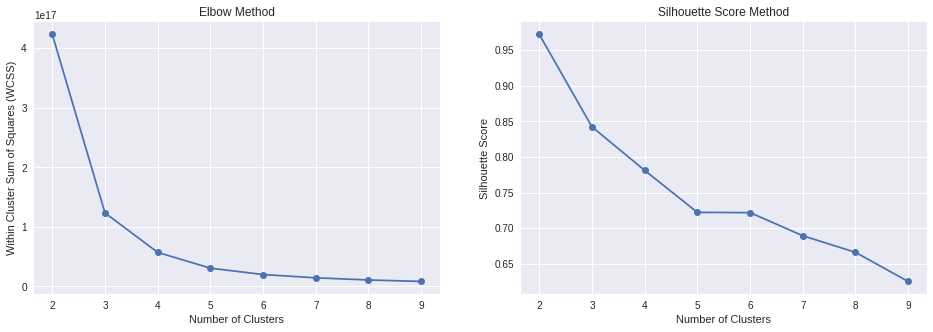

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
x=np.arange(2,10)
ax1.plot(x,wcss,marker='o')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Within Cluster Sum of Squares (WCSS)")
ax1.set_title("Elbow Method")
x=np.arange(2,10)
ax2.plot(x,sil,marker='o')
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")

In [45]:
# As per elbow method, 5 clusters will be used!

In [46]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 4 0 4 0 4 0 4 0 4 4 4 4 2 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 0 0 4 4 4 1
 0 4 4 4 4 0 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 2 4 4 0 4 4 4 2 0 4 4 4 4 4 4 4
 4 4 4 4 1 3 2 0 4 4 0 4 2 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 0 4 4 4 4 4
 2 4 4 4 4 0 0 4 0 4 4 4 0 3 4 4 4 3 4 4 4 0 2 0 4 4 4 2 4 4 4 4 4 4 0 4 4
 4 4 4 4 4 4 0 4 0 4 0 4 4 4 4 4 4 0 0 4 4 4 4 2 3 0 0 4 0 4 0 0 2 4 4 0 4
 4]


In [47]:
df_km["Clus_km"] = labels

In [48]:
# Cluster segmentation
df_km.groupby('Clus_km').mean()

,population,median_age,aged_65_older,gdp_per_capita,diabetes_prevalence
Clus_km,,,,,
0,4.101265e+07,28.308824,7.920706,15252.918529,6.657059
1,1.409664e+09,33.450000,8.315000,10867.693000,10.065000
2,1.129424e+08,32.554545,9.896909,18192.821909,9.201818
3,2.488235e+08,28.540000,7.306000,17978.160800,7.198000
4,5.970337e+06,26.435075,7.526993,17564.808970,7.021045


In [49]:
df_clus1 = df_km[df_km['Clus_km']==0]
print('Number of countries: ',df_clus1['Country/Region'].count())
df_clus1

Number of countries:  34


,Country/Region,population,median_age,aged_65_older,gdp_per_capita,diabetes_prevalence,Clus_km
0,Afghanistan,38928341.0,18.6,2.581,1803.987,9.59,0
2,Algeria,43851043.0,29.1,6.211,13913.839,6.73,0
4,Angola,32866268.0,16.8,2.405,5819.495,3.94,0
6,Argentina,45195777.0,31.9,11.198,18933.907,5.50,0
8,Australia,25499881.0,37.9,15.504,44648.710,5.07,0
31,Cameroon,26545864.0,18.8,3.165,3364.926,7.20,0
32,Canada,37742157.0,41.4,16.984,44017.591,7.37,0
37,Colombia,50882884.0,32.2,7.646,13254.949,7.44,0
42,Cote d'Ivoire,26378275.0,18.7,2.933,3601.006,2.42,0
61,France,65273512.0,42.0,19.718,38605.671,4.77,0


In [50]:
df_clus2 = df_km[df_km['Clus_km']==1]
print('Number of countries: ',df_clus2['Country/Region'].count())
df_clus2

Number of countries:  2


,Country/Region,population,median_age,aged_65_older,gdp_per_capita,diabetes_prevalence,Clus_km
36,China,1.439324e+09,38.7,10.641,15308.712,9.74,1
78,India,1.380004e+09,28.2,5.989,6426.674,10.39,1


In [51]:
df_clus3 = df_km[df_km['Clus_km']==2]
print('Number of countries: ',df_clus3['Country/Region'].count())
df_clus3

Number of countries:  11


,Country/Region,population,median_age,aged_65_older,gdp_per_capita,diabetes_prevalence,Clus_km
13,Bangladesh,164689383.0,27.5,5.098,3523.984,8.38,2
52,Egypt,102334403.0,25.3,5.159,10550.206,17.31,2
58,Ethiopia,114963583.0,19.8,3.526,1729.927,7.47,2
65,Germany,83783945.0,46.6,21.453,45229.245,8.31,2
80,Iran,83992953.0,32.4,5.440,19082.620,9.59,2
86,Japan,126476458.0,48.2,27.049,39002.223,5.72,2
111,Mexico,128932753.0,29.3,6.857,17336.469,13.06,2
133,Philippines,109581085.0,25.2,4.803,7599.188,7.07,2
138,Russia,145934460.0,39.6,14.178,24765.954,6.18,2
171,Turkey,84339067.0,31.6,8.153,25129.341,12.13,2


In [52]:
df_clus4 = df_km[df_km['Clus_km']==3]
print('Number of countries: ',df_clus4['Country/Region'].count())
df_clus4

Number of countries:  5


,Country/Region,population,median_age,aged_65_older,gdp_per_capita,diabetes_prevalence,Clus_km
23,Brazil,212559409.0,33.5,8.552,14103.452,8.11,3
79,Indonesia,273523621.0,29.3,5.319,11188.744,6.32,3
124,Nigeria,206139587.0,18.1,2.751,5338.454,2.42,3
128,Pakistan,220892331.0,23.5,4.495,5034.708,8.35,3
172,US,331002647.0,38.3,15.413,54225.446,10.79,3


In [53]:
df_clus5 = df_km[df_km['Clus_km']==4]
print('Number of countries: ',df_clus5['Country/Region'].count())
df_clus5

Number of countries:  134


,Country/Region,population,median_age,aged_65_older,gdp_per_capita,diabetes_prevalence,Clus_km
1,Albania,2877800.0,38.0,13.188,11803.431,10.08,4
3,Andorra,77265.0,0.0,0.000,0.000,7.97,4
5,Antigua and Barbuda,97928.0,32.1,6.933,21490.943,13.17,4
7,Armenia,2963234.0,35.7,11.232,8787.580,7.11,4
9,Austria,9006400.0,44.4,19.202,45436.686,6.35,4
10,Azerbaijan,10139175.0,32.4,6.018,15847.419,7.11,4
11,Bahamas,393248.0,34.3,8.996,27717.847,13.17,4
12,Bahrain,1701583.0,32.4,2.372,43290.705,16.52,4
14,Barbados,287371.0,39.8,14.952,16978.068,13.57,4
15,Belarus,9449321.0,40.3,14.799,17167.967,5.18,4


# Regression :

In [54]:
def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c))) + 1



The formula for the Sigmoid logistic function is the following:

$$ Y = 1+ \frac{a}{1+ e^{-b(x-c)}}$$

$a$: maximum number of confirmed cases.

$b$: represents the Rise of Sigmoid.

$c$: Controls the curve's steepness.


In [55]:
Country_Train = 'India'

try:
    df['Country/Region'].str.contains(Country_Train)
    print('Found Data!')
except ValueError:
    print('Invalid Country Name')

filter_5 = df['Country/Region']==str(Country_Train)
filter_6 = df['Confirmed']>0
# Requested Country DataFrame :
dfg = df.loc[filter_5 & filter_6]
dfg = dfg.reset_index()
dfg.drop(columns=['index'],inplace=True)
#print(df1.dtypes)
dfg['Day']=dfg.index + 1
#dfg.tail(2)

Found Data!


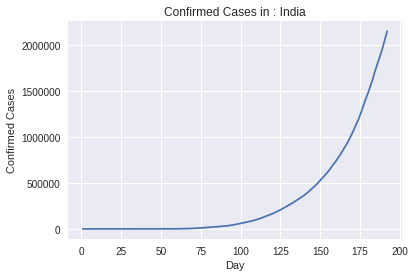

In [56]:
# Display actual curve :

x = dfg['Day']
y = dfg['Confirmed']
plt.plot(x,y)
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed Cases in : '+Country_Train)
plt.show()

# Sigmoid - Logistic Function :

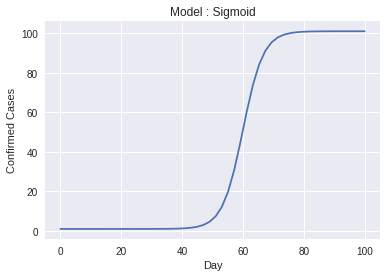

In [57]:
# Selecting Model :

a,b,c=100,0.3,60
x = np.linspace(0,100,50)
y = sigmoid(x,a,b,c)
plt.plot(x,y)
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.title('Model : Sigmoid')
plt.show()

In [58]:
# Train_Test_Split:

from sklearn.model_selection import train_test_split
x = dfg['Day'].values
y = dfg['Confirmed'].values
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.1,shuffle=False)
print('Train set:',(train_x.shape,train_y.shape))
print('Test set:',(test_x.shape,test_y.shape))

Train set: ((172,), (172,))
Test set: ((20,), (20,))


In [59]:

a = dfg['Confirmed'].max()
b = 0.3
c = 100
p0 = (a, b, c)

popt, pcov = sp.optimize.curve_fit(sigmoid,  train_x,  train_y,  p0=p0 )

#x = range(1,dfg.shape[0] + int(popt[2]))
#y_fit = sigmoid(x, *popt)
x = train_x
model_y = sigmoid(train_x,*popt)
    
df_model = pd.DataFrame()
df_model['x'] = x
df_model['y'] = model_y.astype(int)

popt[0]=1.10*popt[0]
popt[1]=1.2*popt[1]
print("Optimized a (the maximum number of confirmed cases): " + str(int(popt[0])))
print("Optimized b (growth rate): " + str(float(popt[1])))
print("Optimized c (the day of the inflexion): " + str(int(popt[2])) + "")




Optimized a (the maximum number of confirmed cases): 3091915
Optimized b (growth rate): 0.05447879099378902
Optimized c (the day of the inflexion): 182


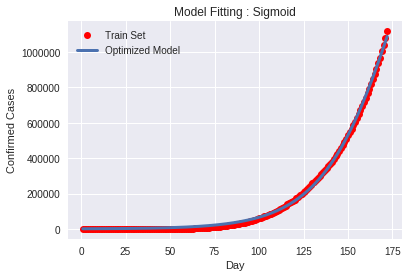

In [60]:
#Model Fitting :


# Re-plotting training data on the fitted model:

plt.plot(train_x,train_y,'ro',label='Train Set')
plt.plot(train_x,model_y,label='Optimized Model',linewidth=3)

plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.title('Model Fitting : Sigmoid')
plt.legend(loc='best')
plt.show()

In [61]:
# Predict using test set :
y_pred = sigmoid(test_x, *popt)

# Evaluation Metrics :
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_pred - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_pred - test_y) ** 2))
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(test_y, y_pred))

Mean absolute error: 67603.01
Residual sum of squares (MSE): 8126016313.75
R2-score: 0.91


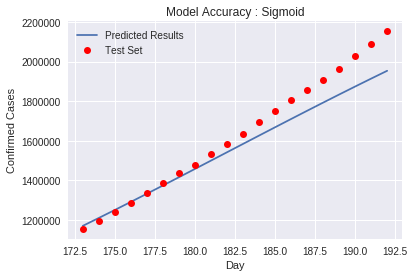

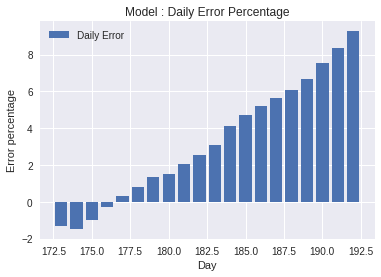

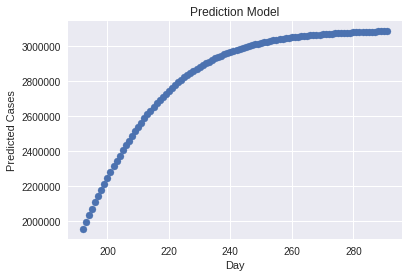

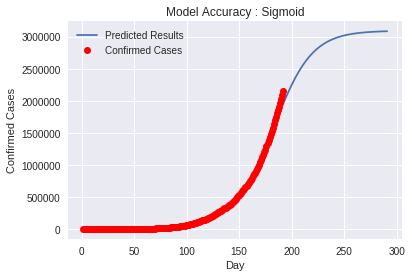

In [62]:
# Plotting predited data and test data:

plt.plot(test_x,y_pred,label='Predicted Results')
plt.plot(test_x,test_y,'ro', label='Test Set')
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.title('Model Accuracy : Sigmoid')

plt.legend(loc='best')
plt.show()

# My evaluation

len_y =  len(test_y)
pred  =  np.ndarray((len_y))
err   =  np.ndarray((len_y))

for i in range(len_y):
    pred[i] = test_y[i] - y_pred[i]
    err[i]  = (pred[i]/test_y[i])*100


# Plotting predited data and test data:

plt.bar(test_x,err,label='Daily Error')
plt.xlabel('Day')
plt.ylabel('Error percentage')
plt.title('Model : Daily Error Percentage')

plt.legend(loc='best')
plt.show()

#Accuracy = 100-(err.mean())
#print('Accuracy of Model is : ',np.round(Accuracy))

pred_x = range(test_x.max(),test_x.max()+100)
y_pred_F = sigmoid(pred_x, *popt)
final_predict = y_pred_F + (err.mean()/100)*y_pred_F
plt.scatter(pred_x,y_pred_F)
plt.xlabel('Day')
plt.ylabel('Predicted Cases')
plt.title('Prediction Model')

plt.show()

#y_pred_F

# Plotting predited data and Confirmed data:

plt.plot(pred_x,y_pred_F,label='Predicted Results')
plt.plot(dfg['Day'],dfg['Confirmed'],'ro', label='Confirmed Cases')
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.title('Model Accuracy : Sigmoid')

plt.legend(loc='best')
plt.show()

# Prediction for next 30 days:

In [63]:
def PredictionForIndia(case_type):
    Country_Train = 'India'

    try:
        df['Country/Region'].str.contains(Country_Train)
        pass
        #print('Found Data!')
    except ValueError:
        print('Invalid Country Name')


    filter_5 = df['Country/Region']==str(Country_Train)
    filter_6 = df[case_type]>0
    # Requested Country DataFrame :
    dfg = df.loc[filter_5 & filter_6]
    dfg = dfg.reset_index()
    dfg.drop(columns=['index'],inplace=True)
    #print(df1.dtypes)
    dfg['Day']=dfg.index + 1
    #dfg.tail(2)

    # Train_Test_Split:

    train_x = dfg['Day']
    train_y = dfg[case_type]

    a = dfg[case_type].max()
    b = 0.3
    c = 100
    p0 = (a, b, c)

    popt, pcov = sp.optimize.curve_fit(sigmoid,  train_x,  train_y,  p0=p0 )

    #x = range(1,dfg.shape[0] + int(popt[2]))
    #y_fit = sigmoid(x, *popt)
    x = train_x
    model_y = sigmoid(train_x,*popt)

    df_model = pd.DataFrame()
    df_model['x'] = x
    df_model['y'] = model_y.astype(int)

    popt[0]=1.10*popt[0]
    popt[1]=1.2*popt[1]
    #print("Optimized a (the maximum number of confirmed cases): " + str(int(popt[0])))
    #print("Optimized b (growth rate): " + str(float(popt[1])))
    #print("Optimized c (the day of the inflexion): " + str(int(popt[2])) + "")


    p_df = pd.DataFrame()
    d = train_x.max()
    days = []
    for x in range(d+1,d+30):
        days.append(x)

    p_df['Day'] = pd.Series(data=days)

    test_x = p_df['Day']
    y_predict_India = sigmoid(test_x, *popt)
    p_df[case_type] = pd.Series(data=y_predict_India)
    t_df = dfg[['Day',case_type]]

    frames=[t_df,p_df]
    prediction = pd.concat(frames,ignore_index=True)
    prediction[case_type]

    fig = go.Figure()

    Confirmed_Cases = fig.add_trace(go.Scatter(x = t_df['Day'], y = t_df[case_type],mode = 'lines+markers',name = case_type))
    Predicted_Cases = fig.add_trace(go.Scatter(x = p_df['Day'], y = p_df[case_type],mode = 'lines+markers', name='Predicted'))

    #fig.show()
    fig_prediction = fig
    
    return fig_prediction

In [64]:
# Total Confirmed cases Prediction:

PredictionForIndia('Confirmed')

In [65]:
# Total Deaths prediction:

PredictionForIndia('Confirmed')

# Finding Essentials Near Your Place : 

In [79]:
address = str(input('Address : '))

Address : Microsoft, Hyderabad


In [80]:
#address = 'Kharghar, Navi Mumbai, India'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

17.4307694 78.34214019335069


In [81]:

search_query_1 = 'Hospital'
search_query_2 = 'Police'
search_query_3 = 'Pharmacy'

# FourSquare API Calls :
CLIENT_ID = 'GAJWRHX4PTOW1VCKFRZHRCFVENCDAT0ZWQLQ2S4SJIH0HNKK' 
CLIENT_SECRET = 'EKFZ4NJHHHJHE11G5TJ5KEI2KTLEUIHO1CNIZO15KOPXZQUG' 
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

LIMIT = 20
radius = 2000

df_temp = pd.DataFrame(columns=['name', 'categories', 'lat', 'lng', 'distance'])
dfE = pd.DataFrame(columns=['name', 'categories', 'lat', 'lng', 'distance'])


Your credentails:
CLIENT_ID: GAJWRHX4PTOW1VCKFRZHRCFVENCDAT0ZWQLQ2S4SJIH0HNKK
CLIENT_SECRET:EKFZ4NJHHHJHE11G5TJ5KEI2KTLEUIHO1CNIZO15KOPXZQUG


In [82]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_1, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']
if len(venues)==0:
    df_Hospital = pd.DataFrame(columns=['name', 'categories', 'location.lat', 'location.lng', 'location.distance'])
    print('No Hospitals found')
else:
    # tranform venues into a dataframe
    df_E = json_normalize(venues)
    df_Hospital = df_E[['name', 'categories', 'location.lat', 'location.lng', 'location.distance']]
    # function that extracts the category of the venue
    def get_category_type(row):
        return search_query_1
    # filter the category for each row
    df_Hospital['categories'] = df_Hospital.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    df_Hospital.columns = [column.split('.')[-1] for column in df_Hospital.columns]
    

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_2, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']
if len(venues)==0:
    df_Police = pd.DataFrame(columns=['name', 'categories', 'location.lat', 'location.lng', 'location.distance'])
    print('No Police stations found')
else:
    # tranform venues into a dataframe
    df_E = json_normalize(venues)
    df_Police = df_E[['name', 'categories', 'location.lat', 'location.lng', 'location.distance']]
    # function that extracts the category of the venue
    def get_category_type(row):
        return search_query_2 
    # filter the category for each row
    df_Police['categories'] = df_Police.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    df_Police.columns = [column.split('.')[-1] for column in df_Police.columns]


url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_3, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']
if len(venues)==0:
    df_Pharmacy = pd.DataFrame(columns=['name', 'categories', 'location.lat', 'location.lng', 'location.distance'])
    print('No Pharmacy stores found')
else:
    # tranform venues into a dataframe
    df_E = json_normalize(venues)
    df_Pharmacy = df_E[['name', 'categories', 'location.lat', 'location.lng', 'location.distance']]
    # function that extracts the category of the venue
    def get_category_type(row):
        return search_query_3
    # filter the category for each row
    df_Pharmacy['categories'] = df_Pharmacy.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    df_Pharmacy.columns = [column.split('.')[-1] for column in df_Pharmacy.columns]

In [83]:
df_Essentials = df_temp.append([ df_Hospital,df_Police,df_Pharmacy ], ignore_index=True)
df_Essentials

,name,categories,lat,lng,distance
0,Contnental Hospital,Hospital,17.426262,78.330028,1380
1,Himagiri Hospital,Hospital,17.441766,78.358564,2130
2,Aakruthi Dental Hospital,Hospital,17.441149,78.359470,2173
3,Sri Krishna Hospitality,Hospital,17.434677,78.351578,1092
4,Continental Hospitals,Hospital,17.417840,78.339761,1461
5,Gachibowli Police Station,Police,17.443517,78.353687,1875
6,Apollo Pharmacy,Pharmacy,17.427274,78.330562,1289
7,Apollo Pharmacy,Pharmacy,17.441996,78.358408,2132


In [84]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

# Marks your location
folium.Marker(
    [latitude, longitude],
    popup='Your Current Location',
    icon=folium.Icon(icon='cloud'),
).add_to(venues_map)

# add the Hospitals 
try:
    for lat, lng, label in zip(df_Hospital.lat, df_Hospital.lng, df_Hospital.name):
        folium.Marker(
            [lat, lng],
            icon=folium.Icon(color='red',icon='info-sign'),
            popup=label,
        ).add_to(venues_map)
except:
    pass



# add the Pharmacy 
try:
    for lat, lng, label in zip(df_Pharmacy.lat, df_Pharmacy.lng, df_Pharmacy.name):
        folium.features.Marker(
            [lat, lng],
            icon=folium.Icon(color='red'),
            popup=label,
        ).add_to(venues_map)
except:
    pass


# add the Polices
try: 
    for lat, lng, label in zip(df_Police.lat, df_Police.lng, df_Police.name):
        folium.features.Marker(
            [lat, lng],
            icon=folium.Icon(color='green',icon='info-sign'),
            popup=label,
        ).add_to(venues_map)
except:
    pass

# display map
venues_map